## Training Pretrained YOLOv8 Object Detection Model Using New Data

In [ ]:
import json
import pandas as pd
import random

# Load the CSV file
csv_path = 'D:/archive/turtles-data/data/metadata_splits.csv'  # Ensure the path is correct
df = pd.read_csv(csv_path)

# Load the original JSON file
json_path = 'D:/archive/turtles-data/data/annotations.json'  # Ensure the path is correct
with open(json_path, 'r') as f:
    data = json.load(f)

# Set a random seed to ensure reproducible results
random.seed(42)

# Get the image IDs for each split in the CSV file and randomly select 60%
def get_random_sample_ids(df, split_name):
    ids = list(set(df[df['split_open'] == split_name]['id']))
    sample_size = int(len(ids) * 0.6)
    return set(random.sample(ids, sample_size))

train_ids = get_random_sample_ids(df, 'train')
test_ids = get_random_sample_ids(df, 'test')
valid_ids = get_random_sample_ids(df, 'valid')

# Separate image and annotation data
train_images = [img for img in data['images'] if img['id'] in train_ids]
test_images = [img for img in data['images'] if img['id'] in test_ids]
valid_images = [img for img in data['images'] if img['id'] in valid_ids]

train_annotations = [ann for ann in data['annotations'] if ann['image_id'] in train_ids]
test_annotations = [ann for ann in data['annotations'] if ann['image_id'] in test_ids]
valid_annotations = [ann for ann in data['annotations'] if ann['image_id'] in valid_ids]

# Retain the original categories and license information
categories = data['categories']
licenses = data.get('licenses', [])

# Construct the JSON structure for the training, test, and validation sets
train_data = {
    "images": train_images,
    "annotations": train_annotations,
    "categories": categories,
    "licenses": licenses
}

test_data = {
    "images": test_images,
    "annotations": test_annotations,
    "categories": categories,
    "licenses": licenses
}

valid_data = {
    "images": valid_images,
    "annotations": valid_annotations,
    "categories": categories,
    "licenses": licenses
}

# Save the training, test, and validation JSON files
output_dir = 'D:/archive/turtles-data/data/'
with open(output_dir + 'annotations_train.json', 'w') as f:
    json.dump(train_data, f)

with open(output_dir + 'annotations_test.json', 'w') as f:
    json.dump(test_data, f)

with open(output_dir + 'annotations_valid.json', 'w') as f:
    json.dump(valid_data, f)


In [ ]:
import os
import json
import shutil
import random

def get_output_dirs(image_id, train_ids, train_labels_dir, test_labels_dir, train_images_dir, test_images_dir):
    """Determine if the image_id belongs to the training or test set and return the corresponding labels and images directories."""
    if image_id in train_ids:
        return train_labels_dir, train_images_dir
    else:
        return test_labels_dir, test_images_dir

def convert_coco_to_yolo(annotations_file, images_dir, output_dir, split_ratio=0.8):
    with open(annotations_file) as f:
        data = json.load(f)

    # Create labels and images directories for training and test sets
    train_labels_dir = os.path.join(output_dir, 'labels', 'train')
    test_labels_dir = os.path.join(output_dir, 'labels', 'test')
    train_images_dir = os.path.join(output_dir, 'images', 'train')
    test_images_dir = os.path.join(output_dir, 'images', 'test')

    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)

    # Get all image IDs and randomly split them into training and test sets according to split_ratio
    image_ids = [img['id'] for img in data['images']]
    random.shuffle(image_ids)
    train_size = int(len(image_ids) * split_ratio)
    train_ids = set(image_ids[:train_size])

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        image_info = next(img for img in data['images'] if img['id'] == image_id)
        width, height = image_info['width'], image_info['height']

        # Convert bounding box coordinates to YOLO format
        x_min, y_min, box_width, box_height = annotation['bbox']
        x_center = (x_min + box_width / 2) / width
        y_center = (y_min + box_height / 2) / height
        w = box_width / width
        h = box_height / height
        category_id = annotation['category_id'] - 1  # YOLO uses 0-based category indexing

        # Select the labels and images directory based on the dataset type
        labels_dir, images_output_dir = get_output_dirs(
            image_id, train_ids, train_labels_dir, test_labels_dir, train_images_dir, test_images_dir
        )

        # Save the label file
        img_name = image_info['file_name'].split('.')[0].split('/')[-1]
        label_path = os.path.join(labels_dir, f"{img_name}.txt")
        with open(label_path, 'a') as f:
            f.write(f"{category_id} {x_center} {y_center} {w} {h}\n")

        # Copy the image to the appropriate folder
        src_image_path = os.path.join(images_dir, image_info['file_name'])
        dest_image_path = os.path.join(images_output_dir, f"{img_name}.jpg")
        if not os.path.exists(dest_image_path):  # Avoid duplicate copying
            shutil.copy2(src_image_path, dest_image_path)

# Execute conversion and generate folders
convert_coco_to_yolo(
    annotations_file='/root/autodl-fs/archive/turtles-data/data/annotations_train.json',
    images_dir='/root/autodl-fs/archive/turtles-data/data',
    output_dir='/root/autodl-fs/archive/turtles-data',
    split_ratio=0.9  
)



In [13]:
# Load pretrained YOLOv8 model
!pip install ultralytics


Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [25]:
from ultralytics import YOLO

# Load the pretrained YOLOv8 model
model = YOLO('yolov8s.pt')  # Load small YOLOv8 model; other options include 'yolov8m.pt', 'yolov8l.pt', etc.

# Configure training
model.train(
    data='/root/autodl-fs/archive/turtles-data/data.yaml',  # Path to the data configuration file
    epochs=15,  # Number of training epochs
    imgsz=512,  # Input image size
    batch=32,  # Batch size
    name='turtle_detection_yolov8',  # Name for saving training results
    project='/root/autodl-fs/archive/turtles-data/runs',  # Path to save results
    device=0,  # Specify GPU device (0 for first GPU, 1 for second, etc.)
    workers=4,  # Set number of workers based on system resources
    dfl=2.5 
)

Ultralytics 8.3.27 🚀 Python-3.8.10 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/root/autodl-fs/archive/turtles-data/data.yaml, epochs=15, time=None, patience=100, batch=32, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=4, project=/root/autodl-fs/archive/turtles-data/runs, name=turtle_detection_yolov811, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_t

train: Scanning /autodl-fs/data/archive/turtles-data/labels/train.cache... 5301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5301/5301 [00:00<?, ?it/s]

train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/AAObEqwWdy.jpg: 12 duplicate labels removed
train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/AAVOLXVRuY.jpg: 15 duplicate labels removed
train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/ABiYreNKBy.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/ABsMUmMvpa.jpg: 18 duplicate labels removed
train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/ABuUaTxraz.jpg: 15 duplicate labels removed
train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/ACJaeIphOE.jpg: 10 duplicate labels removed
train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/ACbKDvUxxW.jpg: 18 duplicate labels removed
train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/ADimiadjYJ.jpg: 8 duplicate labels removed
train: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/train/AERzkmntAa.jpg: 5 duplicate labels rem


val: Scanning /autodl-fs/data/archive/turtles-data/labels/test.cache... 1690 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1690/1690 [00:00<?, ?it/s]

val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/AGFJWDclKY.jpg: 5 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/AGSyRUClGX.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/AOzVZwcgHO.jpg: 5 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/AdfKwOHGZp.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/BJuxmBvSSE.jpg: 6 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/BUHeFqNxdR.jpg: 8 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/BwjyKQCnYN.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/CAluWEgwPX.jpg: 10 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/data/archive/turtles-data/images/test/CQHZgGGoLe.jpg: 5 duplicate labels removed
val: WARNING ⚠️ /autodl-fs/

Plotting labels to /root/autodl-fs/archive/turtles-data/runs/turtle_detection_yolov811/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to /root/autodl-fs/archive/turtles-data/runs/turtle_detection_yolov811
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      9.85G     0.8376     0.9682      1.762        158        512: 100%|██████████| 166/166 [00:26<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:04<00:00,  6.08it/s]

                   all       1690       7404      0.903      0.877       0.93      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      8.42G     0.7962     0.6106      1.696        160        512: 100%|██████████| 166/166 [00:23<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.06it/s]

                   all       1690       7404      0.885       0.87      0.946      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15       8.3G     0.7804     0.5774      1.684        146        512: 100%|██████████| 166/166 [00:23<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.01it/s]


                   all       1690       7404      0.932      0.913      0.954      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      8.32G     0.7754     0.5654      1.678        171        512: 100%|██████████| 166/166 [00:23<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]

                   all       1690       7404      0.953      0.913      0.959      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      8.32G     0.7217     0.5199      1.641        179        512: 100%|██████████| 166/166 [00:23<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]

                   all       1690       7404      0.961      0.933      0.966       0.84


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      8.32G     0.6293     0.4429      1.535         90        512: 100%|██████████| 166/166 [00:24<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]

                   all       1690       7404      0.951      0.942       0.97      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      8.31G     0.6056     0.4209      1.526         82        512: 100%|██████████| 166/166 [00:22<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.07it/s]

                   all       1690       7404       0.96      0.936      0.968       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      8.32G     0.5747      0.394      1.501         95        512: 100%|██████████| 166/166 [00:22<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.17it/s]

                   all       1690       7404      0.966      0.957      0.974      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      8.32G     0.5576     0.3787       1.49         88        512: 100%|██████████| 166/166 [00:22<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.27it/s]

                   all       1690       7404      0.969      0.954      0.977      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      8.34G     0.5368     0.3583      1.472         89        512: 100%|██████████| 166/166 [00:22<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.06it/s]

                   all       1690       7404      0.972      0.958      0.979      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      8.34G     0.5146     0.3381      1.454         87        512: 100%|██████████| 166/166 [00:22<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.16it/s]

                   all       1690       7404      0.972      0.962      0.981      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      8.34G     0.4899      0.319      1.446         97        512: 100%|██████████| 166/166 [00:22<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.06it/s]

                   all       1690       7404      0.973      0.963      0.983      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      8.34G       0.47     0.3047      1.433         92        512: 100%|██████████| 166/166 [00:22<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.06it/s]

                   all       1690       7404      0.976      0.969      0.985      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      8.34G      0.452     0.2893      1.424         92        512: 100%|██████████| 166/166 [00:22<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]

                   all       1690       7404      0.982      0.968      0.986      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      8.34G     0.4342     0.2753       1.41         92        512: 100%|██████████| 166/166 [00:22<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  7.22it/s]

                   all       1690       7404       0.98       0.97      0.987      0.918



15 epochs completed in 0.125 hours.
Optimizer stripped from /root/autodl-fs/archive/turtles-data/runs/turtle_detection_yolov811/weights/last.pt, 22.5MB
Optimizer stripped from /root/autodl-fs/archive/turtles-data/runs/turtle_detection_yolov811/weights/best.pt, 22.5MB

Validating /root/autodl-fs/archive/turtles-data/runs/turtle_detection_yolov811/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.8.10 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]


                   all       1690       7404      0.981       0.97      0.987      0.918
                 shell       1688       1701      0.996      0.996      0.995      0.989
                   fin       1671       4062      0.956      0.934      0.972      0.856
                  head       1641       1641      0.989       0.98      0.994       0.91
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /root/autodl-fs/archive/turtles-data/runs/turtle_detection_yolov811


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f4d23fcd7f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Prediction Phase: Applying YOLOv8 and SAM Models for Object Detection and Segmentation Evaluation

shell IOU : 0.9878      fin IOU : 0.9952      head IOU : 0.8604      


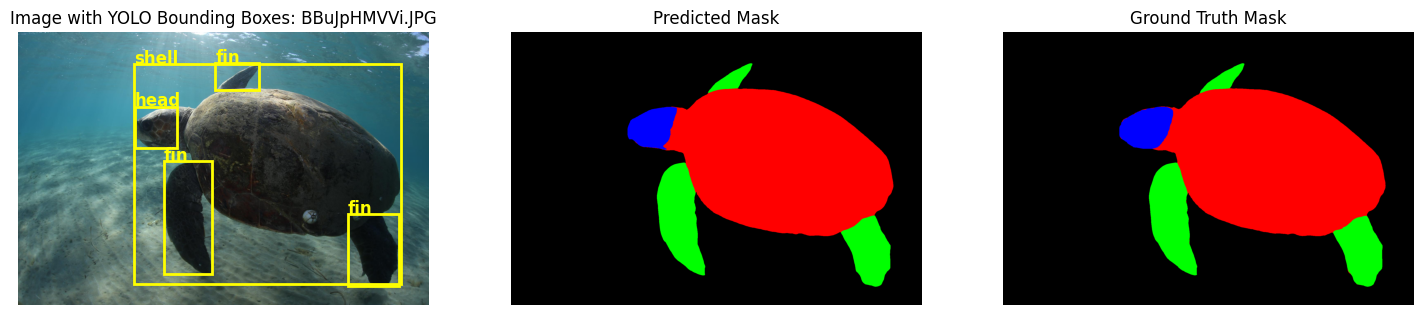

shell IOU : 0.9410      fin IOU : 0.9250      head IOU : 0.9522      


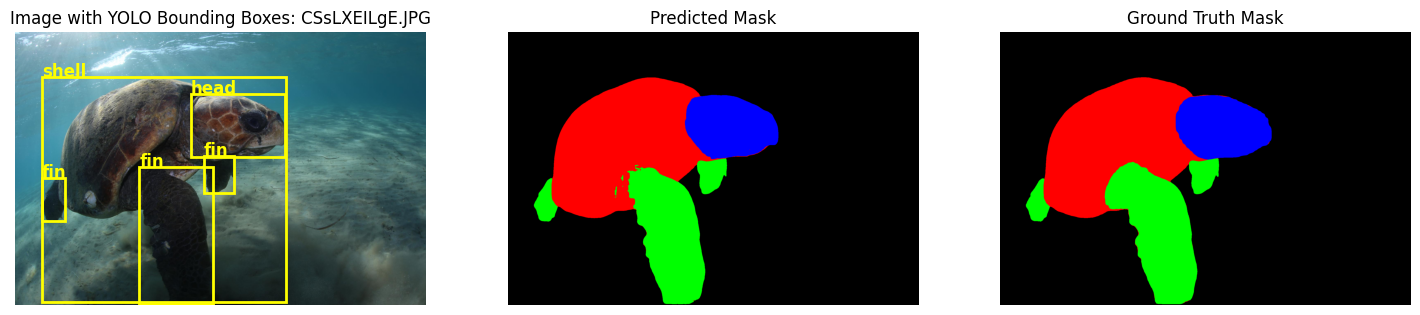

shell IOU : 0.7828      fin IOU : 0.8337      head IOU : 0.9126      


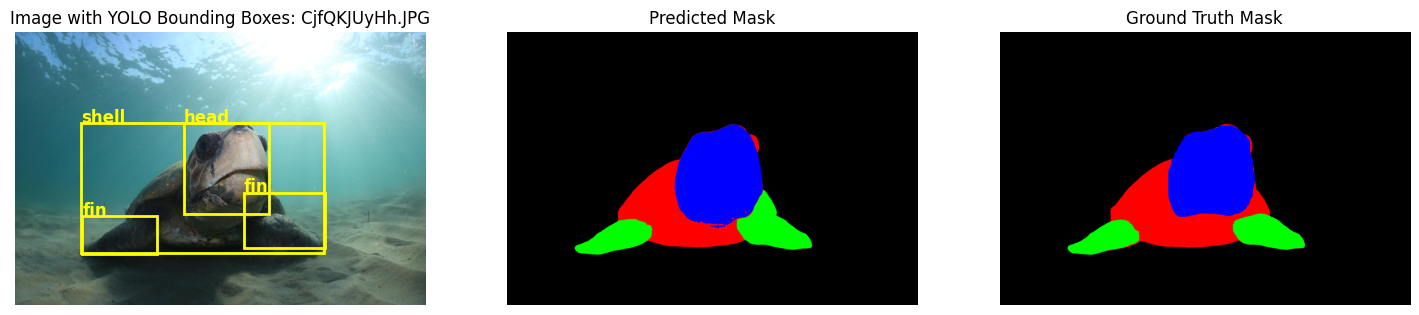

shell IOU : 0.9830      fin IOU : 0.9859      head IOU : 0.8728      


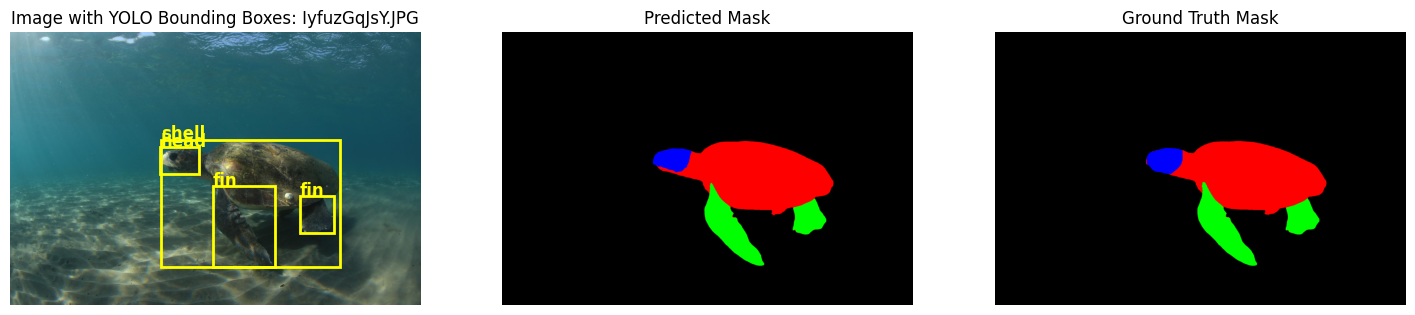

shell IOU : 0.9766      fin IOU : 0.9720      head IOU : 0.9079      


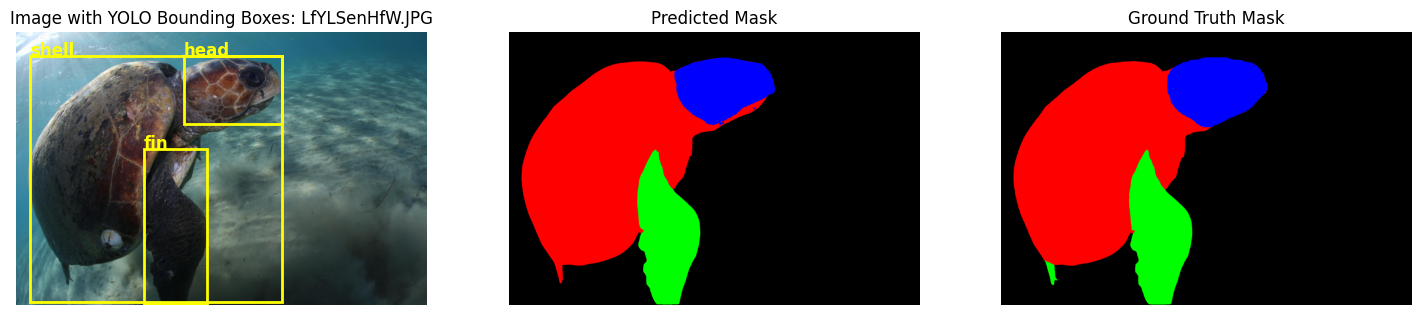

shell IOU : 0.9817      fin IOU : 0.9945      head IOU : 0.7335      


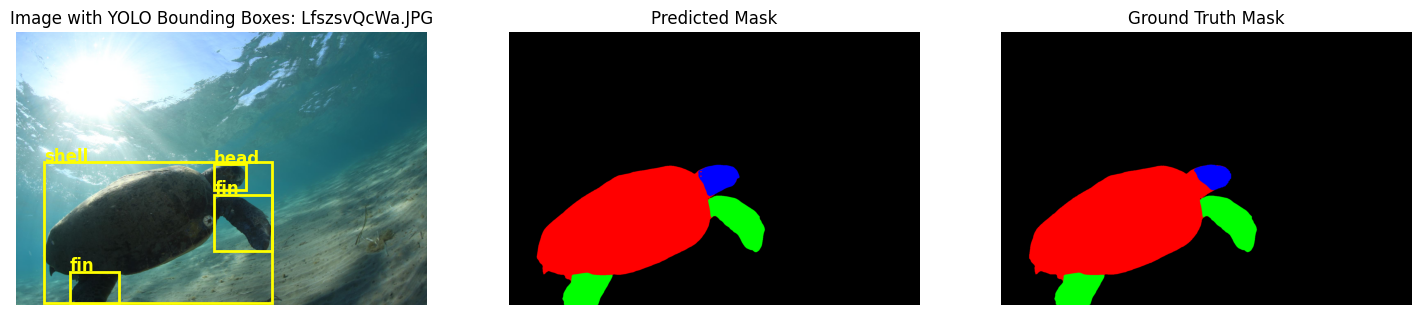

shell IOU : 0.9381      fin IOU : 0.9067      head IOU : 0.7166      


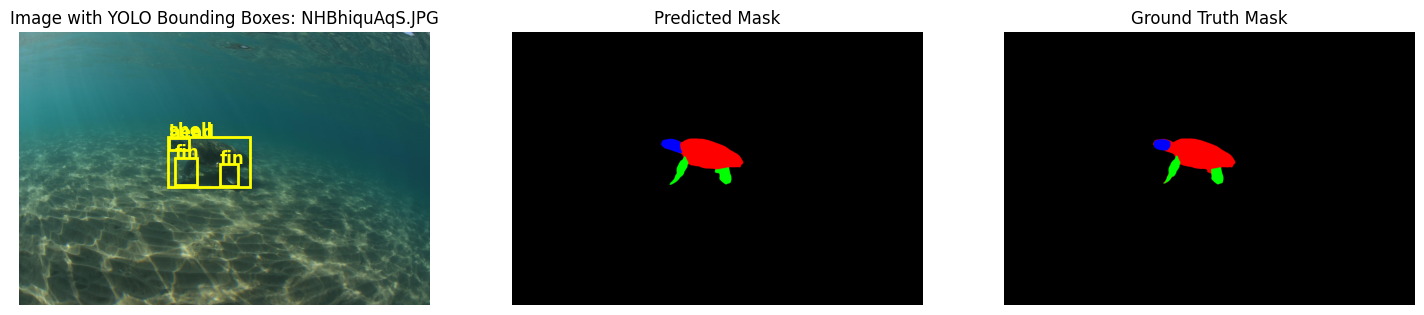

shell IOU : 0.9813      fin IOU : 0.9910      head IOU : 0.7100      


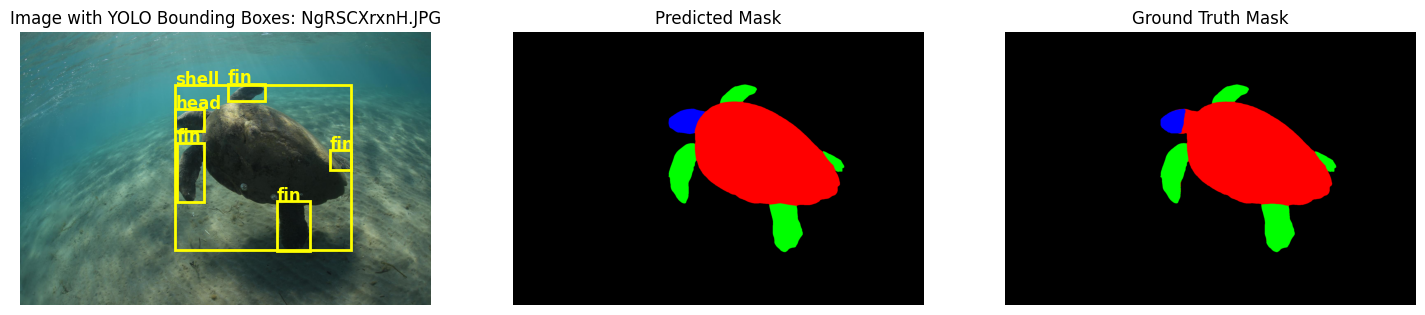

shell IOU : 0.7536      fin IOU : 0.0000      head IOU : 0.0000      


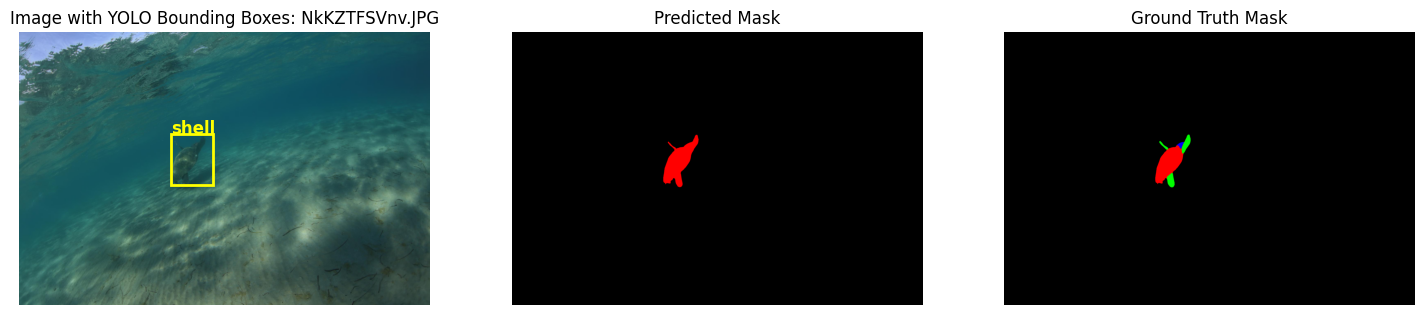

shell IOU : 0.9851      fin IOU : 0.9939      head IOU : 0.7677      


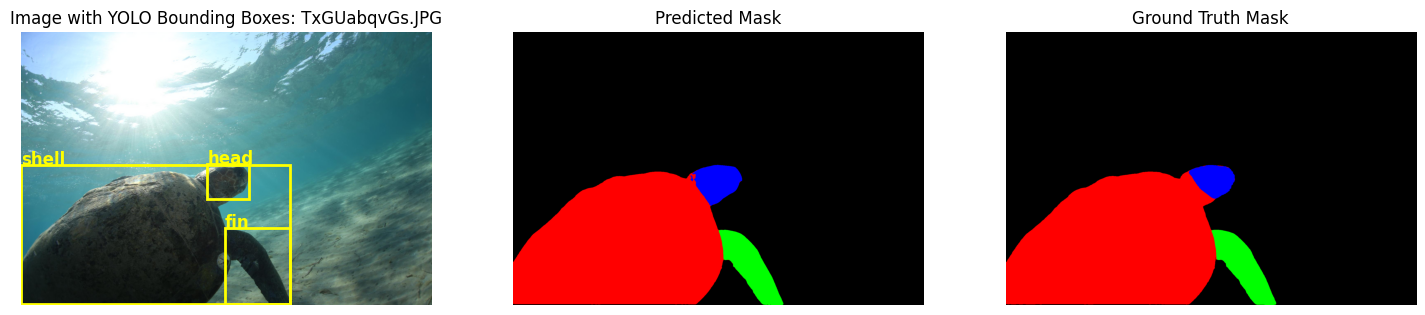

shell IOU : 0.8135      fin IOU : 0.9824      head IOU : 0.8221      


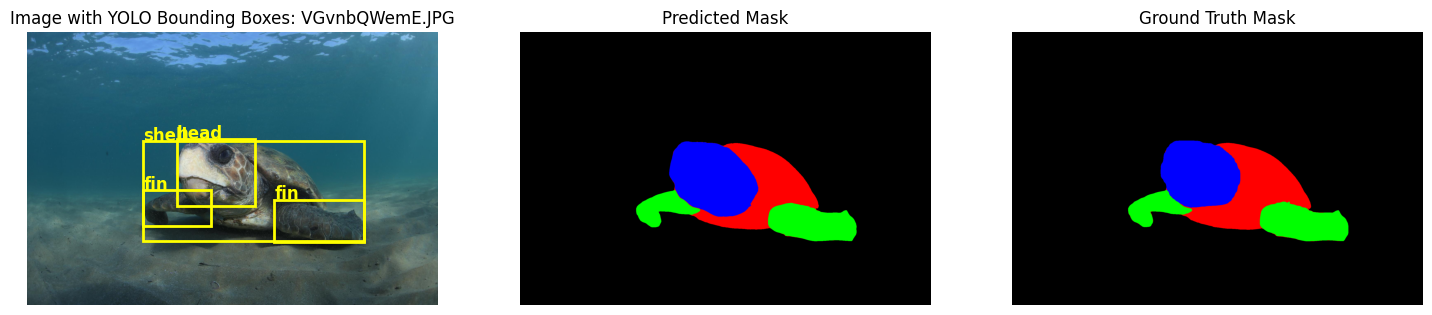

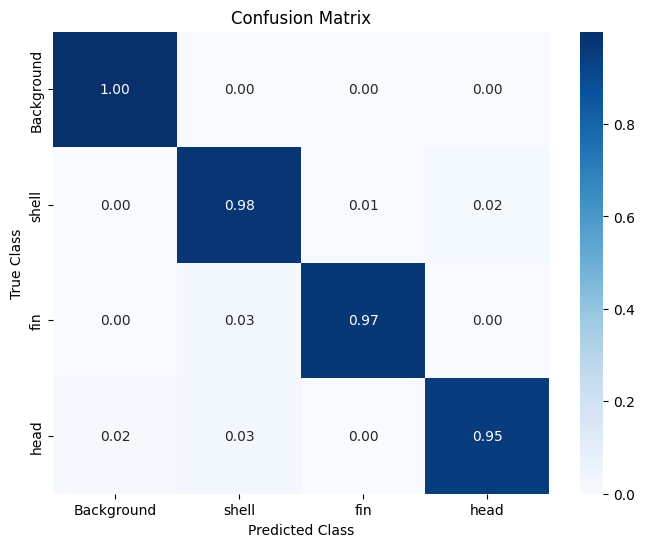

Average IOU for shell: 0.9204
Average IOU for fin: 0.8709
Average IOU for head: 0.7505


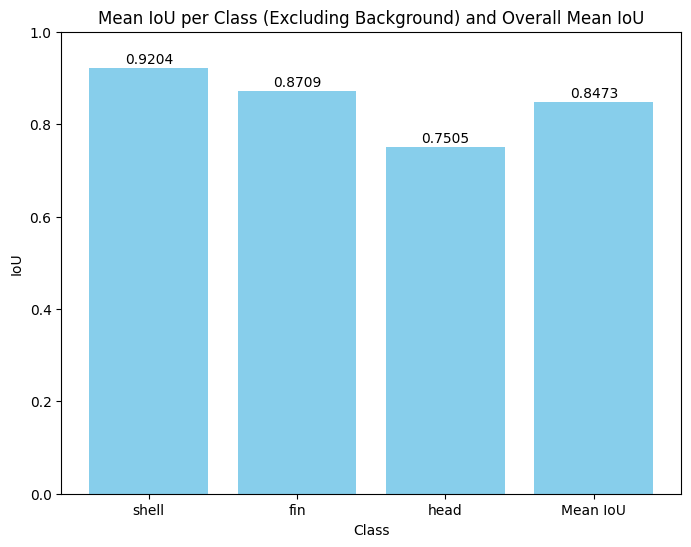

In [26]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from sklearn.metrics import jaccard_score, confusion_matrix
from pycocotools import mask as coco_mask
from ultralytics import YOLO
from collections import defaultdict
import torch
import seaborn as sns
import os

# Configure paths
annotations_path = '/root/autodl-fs/archive/turtles-data/data/annotations_test.json'
image_folder = '/root/autodl-fs/archive/turtles-data/data/'
sam_checkpoint = "/root/autodl-fs/sam_vit_h_4b8939.pth"
yolo_checkpoint = "/root/autodl-fs/archive/turtles-data/runs/turtle_detection_yolov811/weights/best.pt"

# Load JSON file to get all images and annotations information
with open(annotations_path, 'r') as f:
    data = json.load(f)

# Load YOLOv8 and SAM models on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model = YOLO(yolo_checkpoint).to(device)
yolo_model.overrides['verbose'] = False  # Disable YOLO inference verbose output
torch.use_deterministic_algorithms(False)  # Avoid non-deterministic warning
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)

# Initialize IoU accumulations and counts for each category
iou_scores = defaultdict(float)  # Accumulated IoU per category
iou_counts = defaultdict(int)     # Count of masks per category
category_names = ['shell', 'fin', 'head']
conf_matrix_total = np.zeros((len(category_names) + 1, len(category_names) + 1), dtype=int)  # Including background

# Colors for visualization
category_colors = {
    0: [1, 0, 0],     # Red
    1: [0, 1, 0],     # Green
    2: [0, 0, 1],     # Blue
}

def visualize(image_np, pred_colored_mask, gt_colored_mask, image_name, bboxes, class_ids, output_dir="visualizations"):
    save_dir = os.path.join(output_dir)
    os.makedirs(save_dir, exist_ok=True)
    base_name = os.path.basename(image_name)
    output_path = os.path.join(save_dir, f"{os.path.splitext(base_name)[0]}_visualization.png")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot original image with YOLO bounding boxes
    axes[0].imshow(image_np)
    for bbox, class_id in zip(bboxes, class_ids):
        x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='yellow', linewidth=2)
        axes[0].add_patch(rect)
        axes[0].text(x_min, y_min - 5, f"{category_names[int(class_id)]}", color='yellow', fontsize=12, weight='bold')
    axes[0].set_title(f"Image with YOLO Bounding Boxes: {base_name}")
    axes[0].axis("off")
    
    # Plot predicted mask
    axes[1].imshow(pred_colored_mask)
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")
    
    # Plot ground truth mask
    axes[2].imshow(gt_colored_mask)
    axes[2].set_title("Ground Truth Mask")
    axes[2].axis("off")
    
    plt.show()
    # plt.savefig(output_path)
    plt.close(fig)

# Loop through all images in the dataset
for idx, image_info in enumerate(data['images']):
    image_id = image_info['id']
    annotations_info = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
    
    # Load image
    image_path = f"{image_folder}/{image_info['file_name']}"
    image = Image.open(image_path)
    image_np = np.array(image)

    # Initialize blank masks for predictions and ground truth
    pred_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=int)
    gt_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=int)

    # Get YOLOv8 predicted bounding boxes
    results = yolo_model.predict(source=image_path, imgsz=256, device=device)
    bboxes = results[0].boxes.xyxy.cpu().numpy()  # YOLOv8 bounding boxes
    class_ids = results[0].boxes.cls.cpu().numpy()  # YOLOv8 class IDs

    # Set SAM model image
    predictor.set_image(image_np)
    
    # Sort bboxes and class_ids by class_id
    sorted_bboxes = sorted(zip(bboxes, class_ids), key=lambda x: x[1])

    # Process each bbox in sorted order
    for bbox, class_id in sorted_bboxes:
        x_min, y_min, x_max, y_max = bbox
        box_prompt = np.array([x_min, y_min, x_max, y_max]).reshape(1, -1)

        # Predict segmentation mask with SAM and select the highest-confidence mask
        masks, scores, _ = predictor.predict(box=box_prompt)
        best_mask = masks[np.argmax(scores)]  # Select the mask with the highest score

        # Assign the class ID to the pred_mask at the locations where the mask is true
        category_id = int(class_id) + 1  # Convert to category_id starting from 1
        pred_mask[best_mask > 0] = category_id

    # Prepare ground truth mask
    sorted_annotations = sorted(annotations_info, key=lambda ann: ann['category_id'])
    for ann in sorted_annotations:
        category_id = ann['category_id']
        rle_encoded = ann['segmentation']
        gt_mask_category = coco_mask.decode(coco_mask.frPyObjects(rle_encoded, image_np.shape[0], image_np.shape[1])).astype(bool)
        gt_mask[gt_mask_category] = category_id  # Assign the category ID to gt_mask

    # Flatten masks for confusion matrix calculation
    pred_mask_flat = pred_mask.flatten()
    gt_mask_flat = gt_mask.flatten()
    conf_matrix_image = confusion_matrix(gt_mask_flat, pred_mask_flat, labels=range(len(category_names) + 1))
    conf_matrix_total += conf_matrix_image  # Accumulate confusion matrix across all images

    # Calculate IoU for each category
    pred_colored_mask = np.zeros((image_np.shape[0], image_np.shape[1], 3))
    gt_colored_mask = np.zeros((image_np.shape[0], image_np.shape[1], 3))
    
    for class_id, class_name in enumerate(category_names, start=1):
        pred_class_mask = (pred_mask == class_id).astype(int).flatten()
        gt_class_mask = (gt_mask == class_id).astype(int).flatten()
        
        # Calculate IoU
        if np.any(gt_class_mask) or np.any(pred_class_mask):  # Only calculate if there are relevant pixels
            iou = jaccard_score(gt_class_mask, pred_class_mask, average='binary')
            iou_scores[class_name] += iou
            iou_counts[class_name] += 1
            print(f"{class_name} IOU : {iou:.4f}",end = '      ')
        
        # Colorize masks for visualization
        color = category_colors.get(class_id - 1, [1, 1, 1])
        pred_colored_mask[pred_mask == class_id] = color
        gt_colored_mask[gt_mask == class_id] = color
    print()
    # Visualize every 10 images
    visualize(image_np, pred_colored_mask, gt_colored_mask, image_info['file_name'], bboxes, class_ids)
    if idx == 10:
        break

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_total.astype('float') / conf_matrix_total.sum(axis=1, keepdims=True)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Background'] + category_names,
            yticklabels=['Background'] + category_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()
plt.close()

# Calculate and print the average IoU for each category
mean_ious = []
for class_name in category_names:
    if iou_counts[class_name] > 0:
        avg_iou = iou_scores[class_name] / iou_counts[class_name]
        mean_ious.append(avg_iou)
        print(f"Average IOU for {class_name}: {avg_iou:.4f}")
    else:
        mean_ious.append(0)
        print(f"No predictions for {class_name}")

# Plot Mean IoU per Class
plt.figure(figsize=(8, 6))
bars = plt.bar(category_names + ["Mean IoU"], mean_ious + [np.mean(mean_ious)], color='skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center')
plt.ylim(0, 1)
plt.xlabel("Class")
plt.ylabel("IoU")
plt.title("Mean IoU per Class (Excluding Background) and Overall Mean IoU")
plt.show()
plt.close()
